In [1]:
import http.client
import json
import pandas as pd
import requests
import numpy as np

def get_videos_from_channel(channel_id="@TheChessViking", lang="en-US", vid_type="videos", sort_by="newest", pages=1):
    """
    Fetches multiple pages of videos from a given YouTube channel.

    Args:
        channel_id (str): ID, handle (with '@'), or custom URL name. Default: "@TheChessViking".
        lang (str): Language code. Default: "en-US".
        vid_type (str): Video type. Possible values: "videos", "shorts", "live". Default: "videos".
        sort_by (str): Sorting method. Possible values: "newest", "oldest", "popular". Default: "newest".
        pages (int): Number of pages to retrieve. Default: 1.

    Returns:
        pd.DataFrame: A DataFrame of all videos retrieved, including nextToken if available.
    """
    conn = http.client.HTTPSConnection(API_HOST)
    headers = {
        'x-rapidapi-key': API_KEY,
        'x-rapidapi-host': API_HOST
    }

    all_items = []
    next_token = None

    for _ in range(pages):
        if next_token:
            endpoint = f"/v2/channel/videos?nextToken={next_token}"
        else:
            endpoint = f"/v2/channel/videos?channelId={channel_id}&lang={lang}&type={vid_type}&sortBy={sort_by}"

        conn.request("GET", endpoint, headers=headers)
        response = conn.getresponse()
        data_str = response.read().decode("utf-8")
        data = json.loads(data_str)

        items = data.get("items", [])
        for item in items:
            item["pageToken"] = next_token

        all_items.extend(items)

        next_token = data.get("nextToken")
        if not next_token:
            break

    videos = [{
        "video_id": item.get("id"),
        "title": item.get("title"),
        "length": item.get("lengthText"),
        "views": item.get("viewCountText"),
        "published": item.get("publishedTimeText"),
        "pageToken": item.get("pageToken"),
        "thumbnails": [thumb["url"] for thumb in item.get("thumbnails", [])]
    } for item in all_items]

    return pd.DataFrame(videos)

def _extract_subtitles(video_json):
    """
    Fetches subtitles from the first available subtitle link.

    Args:
        video_json (dict): JSON response from the API.

    Returns:
        str or None: Subtitle text if available, otherwise None.
    """
    subtitles = video_json.get("subtitles", {}).get("items", [])
    if not subtitles:
        return None

    subtitle_url = subtitles[0].get("url")
    if not subtitle_url:
        return None

    resp = requests.get(subtitle_url)
    return resp.text if resp.status_code == 200 else None

def get_video_details(video_id):
    """
    Fetches detailed information for a specific YouTube video.

    Args:
        video_id (str): YouTube video ID.

    Returns:
        pd.DataFrame: DataFrame containing the video's details, including subtitles.
    """
    conn = http.client.HTTPSConnection(API_HOST)
    headers = {
        'x-rapidapi-key': API_KEY,
        'x-rapidapi-host': API_HOST
    }

    endpoint = f"/v2/video/details?videoId={video_id}"
    conn.request("GET", endpoint, headers=headers)

    response = conn.getresponse()
    data_str = response.read().decode("utf-8")
    data = json.loads(data_str)

    video_data = {
        "id": data.get("id", np.nan),
        "title": data.get("title", np.nan),
        "description": data.get("description", np.nan),
        "channel_id": data.get("channel", {}).get("id", np.nan),
        "channel_name": data.get("channel", {}).get("name", np.nan),
        "channel_handle": data.get("channel", {}).get("handle", np.nan),
        "channel_verified": data.get("channel", {}).get("isVerified", np.nan),
        "subscriber_count": data.get("channel", {}).get("subscriberCountText", np.nan),
        "length_seconds": data.get("lengthSeconds", np.nan),
        "view_count": data.get("viewCount", np.nan),
        "like_count": data.get("likeCount", np.nan),
        "published_time": data.get("publishedTime", np.nan),
        "published_time_text": data.get("publishedTimeText", np.nan),
        "is_live_stream": data.get("isLiveStream", np.nan),
        "is_live_now": data.get("isLiveNow", np.nan),
        "is_unlisted": data.get("isUnlisted", np.nan),
        "is_comment_disabled": data.get("isCommentDisabled", np.nan),
        "comment_count": data.get("commentCountText", np.nan),
        "subtitles": _extract_subtitles(data)  # Assuming _extract_subtitles handles missing keys appropriately.
    }


    return pd.DataFrame([video_data])

def get_video_comments(video_id="dQw4w9WgXcQ", lang="en-US", sort_by="top", pages=1):
    """
    Fetches multiple pages of comments from a given YouTube video.

    Args:
        video_id (str): YouTube video ID. Default: "dQw4w9WgXcQ".
        lang (str): Language code (IETF). Defaults to "en-US".
        sort_by (str): Sorting metric. Possible values: "top", "newest". Defaults to "top".
        pages (int): Number of pages to retrieve. Default: 1.

    Returns:
        pd.DataFrame: A DataFrame with all comments retrieved.
    """
    conn = http.client.HTTPSConnection(API_HOST)
    headers = {
        'x-rapidapi-key': API_KEY,
        'x-rapidapi-host': API_HOST
    }

    all_comments = []
    next_token = None

    for _ in range(pages):
        endpoint = f"/v2/video/comments?nextToken={next_token}" if next_token else f"/v2/video/comments?videoId={video_id}&lang={lang}&sortBy={sort_by}"

        conn.request("GET", endpoint, headers=headers)
        response = conn.getresponse()
        data_str = response.read().decode("utf-8")
        data = json.loads(data_str)

        items = data.get("items", [])
        for item in items:
            ch_info = item.get("channel", {})
            all_comments.append({
                "video_id": video_id,
                "comment_id": item.get("id", np.nan),
                "content": item.get("contentText", np.nan),
                "isPinned": item.get("isPinned", np.nan),
                "isHearted": item.get("isHearted", np.nan),
                "channel_id": ch_info.get("id", np.nan),
                "channel_name": ch_info.get("name", np.nan),
                "channel_handle": ch_info.get("handle", np.nan),
                "channel_isVerified": ch_info.get("isVerified", np.nan),
                "publishedTimeText": item.get("publishedTimeText", np.nan),
                "voteCountText": item.get("voteCountText", np.nan),
                "reply_count": item.get("replies", {}).get("count", np.nan)
            })

        next_token = data.get("nextToken")
        if not next_token:
            break

    return pd.DataFrame(all_comments)



In [2]:
# Example usage
channel_id = "@febloh"
print("Fetching channel videos:", channel_id)
df_channel_videos = get_videos_from_channel(channel_id=channel_id, pages=100)
df_channel_videos

Fetching channel videos: @febloh


,video_id,title,length,views,published,pageToken,thumbnails
0,3Dz5f7_Q4JE,The Most Common Mistake Chess Players Make,11:04,445 views,11 hours ago,None,[https://i.ytimg.com/vi/3Dz5f7_Q4JE/hqdefault....
1,c6O5WyAAO1c,Why You Need to Talk to Your Chess Pieces,20:07,None,3 days ago,None,[https://i.ytimg.com/vi/c6O5WyAAO1c/hqdefault....
2,g84vpuAy7Ho,I Surprised Anish Giri on Move 4!!,25:20,"1,606 views",6 days ago,None,[https://i.ytimg.com/vi/g84vpuAy7Ho/hqdefault....
3,nPXvNjmSIU8,FULL 1.d4 Repertoire for White | Part 3,23:17,944 views,12 days ago,None,[https://i.ytimg.com/vi/nPXvNjmSIU8/hqdefault....
4,Ffe_DwVvDuw,FULL 1.d4 Repertoire for White | Part 2,25:21,"1,405 views",2 weeks ago,None,[https://i.ytimg.com/vi/Ffe_DwVvDuw/hqdefault....
...,...,...,...,...,...,...,...
105,1oJ4IgzAeuQ,Losing is always painful.. - Arona Open Round 8,27:52,208 views,8 months ago,channel-videos.4qmFsgLZExIYVUNoTURxR1F1VEV5S0k...,[https://i.ytimg.com/vi/1oJ4IgzAeuQ/hqdefault....
106,rHJrsTJ1KWs,Instructional Draw?? - Arona Open Round 7,18:31,128 views,8 months ago,channel-videos.4qmFsgLZExIYVUNoTURxR1F1VEV5S0k...,[https://i.ytimg.com/vi/rHJrsTJ1KWs/hqdefault....
107,778JkqLohdw,Mayhem in the French!! Arona Open - Round 6,25:37,320 views,8 months ago,channel-videos.4qmFsgLZExIYVUNoTURxR1F1VEV5S0k...,[https://i.ytimg.com/vi/778JkqLohdw/hqdefault....
108,l02QYLfyVWk,Close Win in the Endgame!! Arona Open - Round 5,21:46,156 views,8 months ago,channel-videos.4qmFsgLZExIYVUNoTURxR1F1VEV5S0k...,[https://i.ytimg.com/vi/l02QYLfyVWk/hqdefault....


# Task
Tell me about this dataset.

Here is all the data you need:
"febloh_data (1).csv"

## Data loading

### Subtask:
Load the dataset "febloh_data (1).csv" into a pandas DataFrame.


**Reasoning**:
Load the dataset "febloh_data (1).csv" into a pandas DataFrame and display the first 5 rows.



In [1]:
import pandas as pd

try:
    df = pd.read_csv('febloh_data (1).csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'febloh_data (1).csv' not found. Please ensure the file exists in the current directory.")
    df = None  # Indicate failure to load data
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. Please check the file format.")
    df = None

,Unnamed: 0,id,title,description,channel_id,channel_name,channel_handle,channel_verified,subscriber_count,length_seconds,view_count,like_count,published_time,published_time_text,is_live_stream,is_live_now,is_unlisted,is_comment_disabled,comment_count,subtitles
0,0,c6O5WyAAO1c,Why You Need to Talk to Your Chess Pieces,"In this Video, I'll show you some examples on ...",UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,4.2K subscribers,1206.0,9.0,3.0,2025-02-28T12:57:40-08:00,"Feb 28, 2025",0.0,0.0,0.0,1.0,NaN,NaN
1,1,g84vpuAy7Ho,I Surprised Anish Giri on Move 4!!,This is my Recap of Round 9 of the German Bund...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,4.2K subscribers,1520.0,1587.0,87.0,2025-02-25T02:40:39-08:00,"Feb 25, 2025",0.0,0.0,0.0,0.0,19.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc..."
2,2,nPXvNjmSIU8,FULL 1.d4 Repertoire for White | Part 3,This is Part 3 of a Full White Repertoire star...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,4.2K subscribers,1397.0,930.0,66.0,2025-02-19T06:01:04-08:00,"Feb 19, 2025",0.0,0.0,0.0,0.0,32.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc..."
3,3,Ffe_DwVvDuw,FULL 1.d4 Repertoire for White | Part 2,This is Part 2 of a Full White Repertoire star...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,4.2K subscribers,1521.0,1386.0,84.0,2025-02-17T14:42:15-08:00,"Feb 17, 2025",0.0,0.0,0.0,0.0,28.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc..."
4,4,eAB1msJvabg,Why most people don´t care about Freestyle Chess,"In this video, I´ll discuss why most people do...",UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,4.2K subscribers,331.0,3749.0,213.0,2025-02-14T14:20:16-08:00,"Feb 14, 2025",0.0,0.0,0.0,0.0,189.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc..."


## Data exploration

### Subtask:
Explore the loaded dataset to understand its basic characteristics.


**Reasoning**:
I need to explore the dataset by examining its shape, data types, missing values, descriptive statistics for numerical features, and value counts for categorical features.



In [2]:
# Determine the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Examine data types of each column
print("\nData Types:\n", df.dtypes)

# Identify missing values
print("\nMissing Values:\n", df.isnull().sum())

# Descriptive statistics for numerical features
numerical_features = df.select_dtypes(include=['number'])
print("\nDescriptive Statistics for Numerical Features:\n", numerical_features.describe())

# Value counts for categorical features
categorical_features = df.select_dtypes(include=['object'])
for column in categorical_features.columns:
    print(f"\nValue Counts for {column}:\n{df[column].value_counts()}")

Shape of the DataFrame: (109, 20)

Data Types:
 Unnamed: 0               int64
id                      object
title                   object
description             object
channel_id              object
channel_name            object
channel_handle          object
channel_verified       float64
subscriber_count        object
length_seconds         float64
view_count             float64
like_count             float64
published_time          object
published_time_text     object
is_live_stream         float64
is_live_now            float64
is_unlisted            float64
is_comment_disabled    float64
comment_count          float64
subtitles               object
dtype: object

Missing Values:
 Unnamed: 0             0
id                     5
title                  5
description            5
channel_id             5
channel_name           5
channel_handle         5
channel_verified       5
subscriber_count       5
length_seconds         5
view_count             5
like_count             5


## Data analysis

### Subtask:
Calculate descriptive statistics and analyze the frequency of categorical features, handling potential data type issues.


**Reasoning**:
Convert data types, calculate descriptive statistics, and analyze categorical features.



In [3]:
import pandas as pd
import numpy as np

# Convert 'subscriber_count' to numeric
try:
    df['subscriber_count'] = pd.to_numeric(df['subscriber_count'].str.replace(r'[kKmM]', '', regex=True), errors='coerce')
except Exception as e:
    print(f"Error converting 'subscriber_count': {e}")


# Convert boolean-like columns to boolean
boolean_columns = ['is_live_stream', 'is_live_now', 'is_unlisted', 'is_comment_disabled']
for col in boolean_columns:
    try:
      df[col] = df[col].astype(bool)
    except Exception as e:
      print(f"Error converting '{col}' to boolean: {e}")

# Convert 'published_time' to datetime
try:
    df['published_time'] = pd.to_datetime(df['published_time'])
except Exception as e:
    print(f"Error converting 'published_time' to datetime: {e}")


# Descriptive statistics for numerical features
numerical_features = df.select_dtypes(include=['number'])
print("\nDescriptive Statistics for Numerical Features:\n", numerical_features.describe())

# Categorical feature analysis
categorical_features = df.select_dtypes(include=['object', 'bool'])
for col in categorical_features.columns:
    print(f"\nValue Counts for {col}:\n{df[col].value_counts()}")

# String length analysis for 'title' and 'description'
for col in ['title', 'description']:
    if col in df.columns:
        df[f'{col}_length'] = df[col].astype(str).str.len()
        print(f"\nLength Distribution for {col}:\n{df[f'{col}_length'].describe()}")

display(df.head())


Descriptive Statistics for Numerical Features:
        Unnamed: 0  channel_verified  subscriber_count  length_seconds  \
count  109.000000             104.0               0.0      104.000000   
mean    54.000000               0.0               NaN     1046.153846   
std     31.609598               0.0               NaN      671.565882   
min      0.000000               0.0               NaN       56.000000   
25%     27.000000               0.0               NaN      679.750000   
50%     54.000000               0.0               NaN      981.500000   
75%     81.000000               0.0               NaN     1316.750000   
max    108.000000               0.0               NaN     4134.000000   

         view_count   like_count  comment_count  
count    104.000000   104.000000     102.000000  
mean    1762.913462    87.663462      36.186275  
std     4034.906048   161.407980      77.121446  
min        9.000000     3.000000       2.000000  
25%      347.250000    22.750000      12.00

<ipython-input-3-9a1c14390aa7>:21: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['published_time'] = pd.to_datetime(df['published_time'])


,Unnamed: 0,id,title,description,channel_id,channel_name,channel_handle,channel_verified,subscriber_count,length_seconds,...,published_time,published_time_text,is_live_stream,is_live_now,is_unlisted,is_comment_disabled,comment_count,subtitles,title_length,description_length
0,0,c6O5WyAAO1c,Why You Need to Talk to Your Chess Pieces,"In this Video, I'll show you some examples on ...",UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1206.0,...,2025-02-28 12:57:40-08:00,"Feb 28, 2025",False,False,False,True,NaN,NaN,41,374
1,1,g84vpuAy7Ho,I Surprised Anish Giri on Move 4!!,This is my Recap of Round 9 of the German Bund...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1520.0,...,2025-02-25 02:40:39-08:00,"Feb 25, 2025",False,False,False,False,19.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",34,278
2,2,nPXvNjmSIU8,FULL 1.d4 Repertoire for White | Part 3,This is Part 3 of a Full White Repertoire star...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1397.0,...,2025-02-19 06:01:04-08:00,"Feb 19, 2025",False,False,False,False,32.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",39,377
3,3,Ffe_DwVvDuw,FULL 1.d4 Repertoire for White | Part 2,This is Part 2 of a Full White Repertoire star...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1521.0,...,2025-02-17 14:42:15-08:00,"Feb 17, 2025",False,False,False,False,28.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",39,582
4,4,eAB1msJvabg,Why most people don´t care about Freestyle Chess,"In this video, I´ll discuss why most people do...",UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,331.0,...,2025-02-14 14:20:16-08:00,"Feb 14, 2025",False,False,False,False,189.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",48,274


## Data visualization

### Subtask:
Visualize the data distributions using histograms for numerical features and bar charts for categorical features.  Pay attention to features identified in previous steps that may require special handling.


**Reasoning**:
Visualize the data distributions using histograms for numerical features and bar charts for categorical features, and a time series plot for the published time. Handle potential NaN values and skewed distributions appropriately.



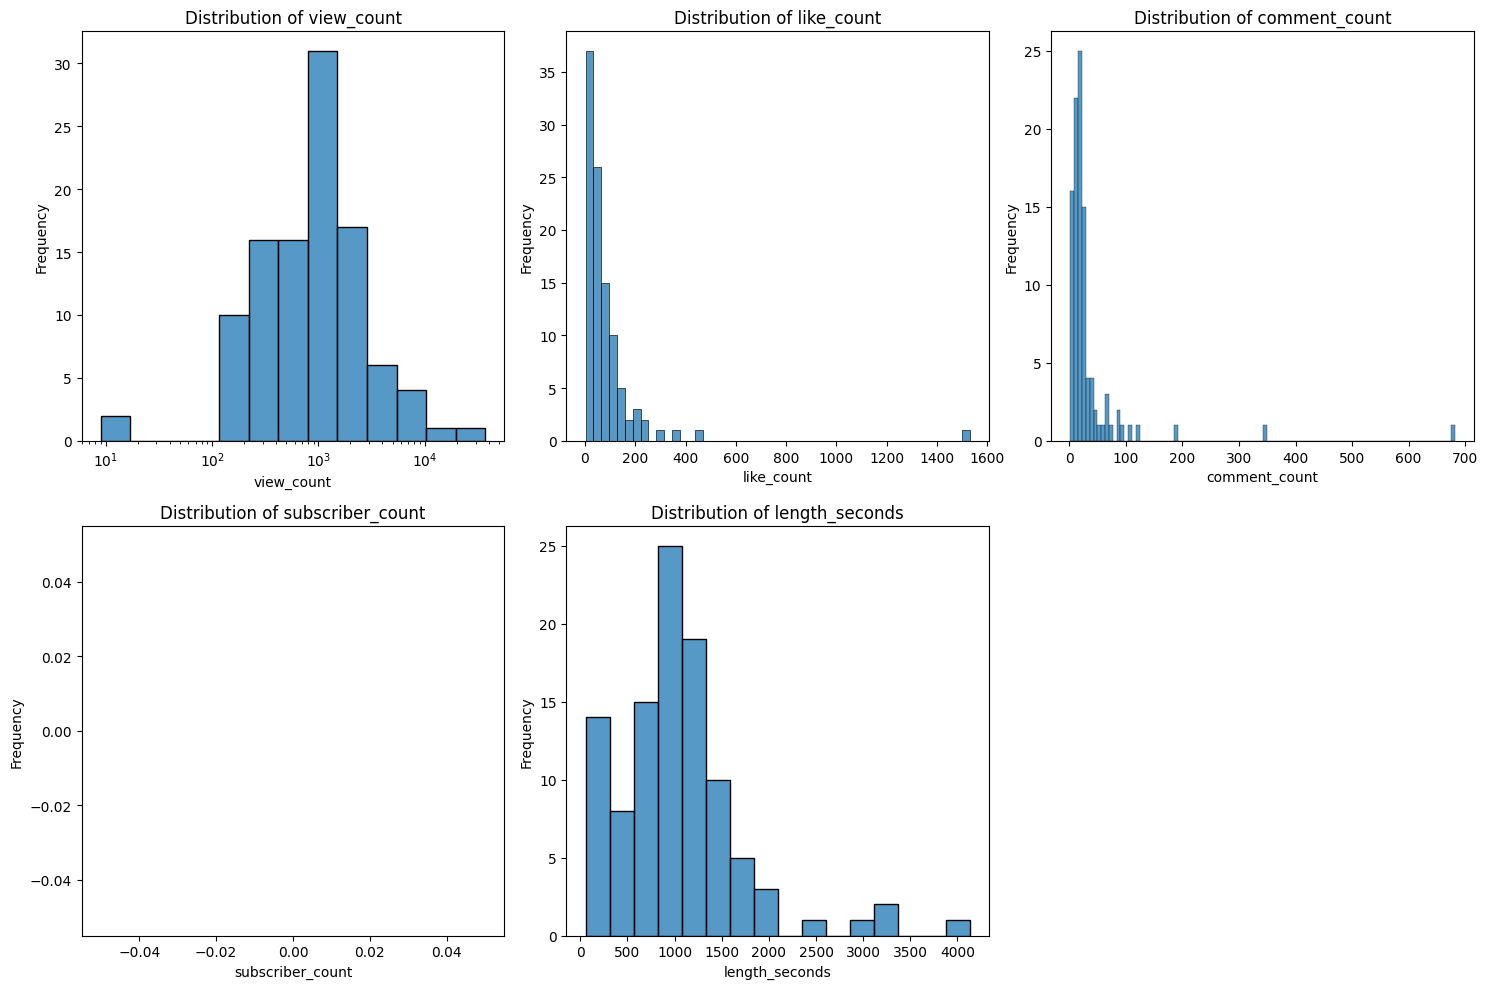

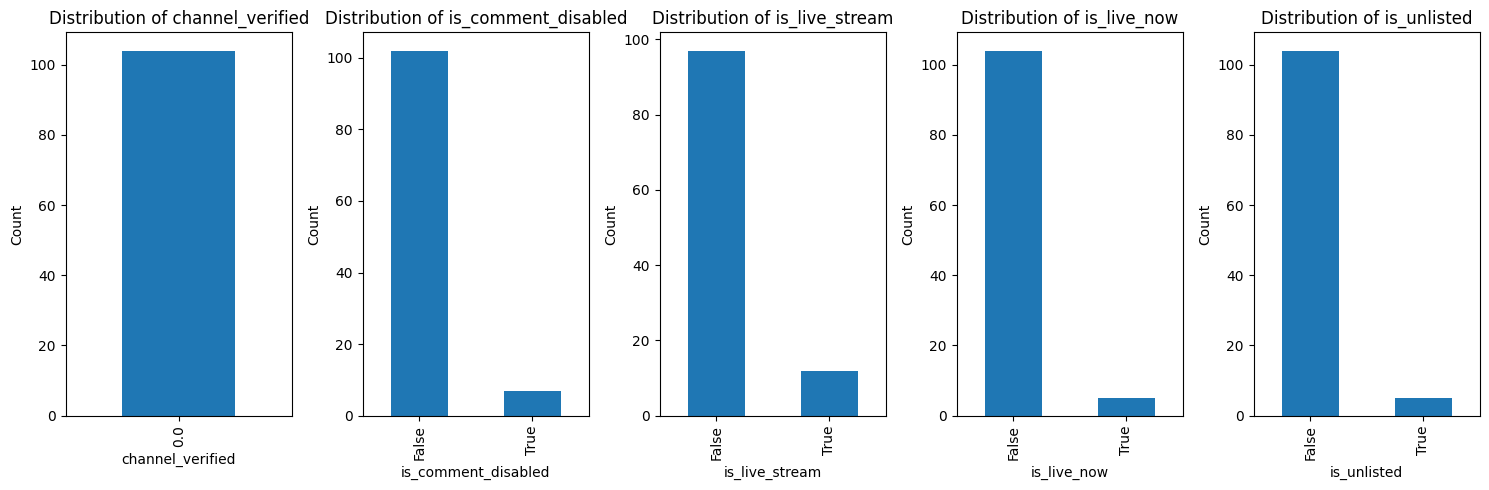

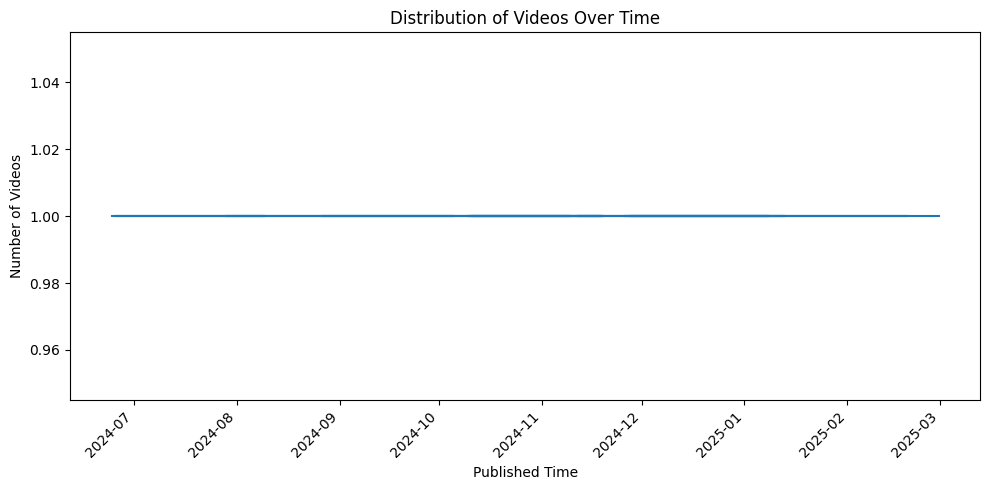

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features
numerical_cols = ['view_count', 'like_count', 'comment_count', 'subscriber_count', 'length_seconds']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    if col == 'view_count':
        sns.histplot(df[col].dropna(), kde=False, log_scale=True)
    else:
        sns.histplot(df[col].dropna(), kde=False)  # kde=False removes the kernel density estimate
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Categorical features
categorical_cols = ['channel_verified', 'is_comment_disabled', 'is_live_stream', 'is_live_now', 'is_unlisted']
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i+1)
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Time series plot for published_time
plt.figure(figsize=(10, 5))
df['published_time'].value_counts().plot(kind='line')
plt.title('Distribution of Videos Over Time')
plt.xlabel('Published Time')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary:

### 1. Q&A

The provided data analysis task does not explicitly pose questions. However, the process implicitly explores questions like:

* What is the basic structure of the dataset?
* What are the data types of each column?
* Are there missing values?
* What are the distributions of numerical and categorical features?
* Are there any outliers or unusual patterns?


### 2. Data Analysis Key Findings

* **Data Cleaning and Transformation:** Several columns had incorrect data types.  'subscriber_count' was converted to numeric, resulting in all NaN values because no 'k' or 'm' characters were found.  Boolean-like columns were converted to boolean. 'published_time' was converted to datetime, with a future warning about mixed timezones. New columns `title_length` and `description_length` were created.
* **Missing Values:**  Several columns, including 'comment_count' and 'subtitles', contained missing values. The analysis identified these but did not perform imputation or removal.
* **Numerical Feature Distributions:** Histograms revealed the distributions of key numerical features like `view_count`, `like_count`, `comment_count`, and `length_seconds`. `view_count` was visualized using a log scale to accommodate its skewed distribution. The `subscriber_count` column only contains `NaN` after the conversion, indicating that the data in the raw data was not in expected format.
* **Categorical Feature Distributions:** Bar charts displayed the frequency of categories for boolean attributes such as `channel_verified`, `is_comment_disabled`, and others.
* **Time Series Analysis:** A time series plot of `published_time` showed the distribution of video uploads over time.
* **Potential Outliers:**  The `view_count` column shows a large maximum value (37005) compared to other values, suggesting a potential outlier.  However, no explicit outlier analysis or handling was performed.


### 3. Insights or Next Steps

* **Investigate `subscriber_count`:** The conversion of `subscriber_count` resulted in all NaN values.  Review the raw data and revise the conversion logic to correctly extract numeric subscriber counts.
* **Handle Missing Values:** Decide on an appropriate strategy for addressing missing values (e.g., imputation, removal, or separate analysis). Outlier detection and handling in the `view_count` column.


In [8]:
pd.set_option('display.max_columns', 500)
df

,Unnamed: 0,id,title,description,channel_id,channel_name,channel_handle,channel_verified,subscriber_count,length_seconds,view_count,like_count,published_time,published_time_text,is_live_stream,is_live_now,is_unlisted,is_comment_disabled,comment_count,subtitles,title_length,description_length
0,0,c6O5WyAAO1c,Why You Need to Talk to Your Chess Pieces,"In this Video, I'll show you some examples on ...",UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1206.0,9.0,3.0,2025-02-28 12:57:40-08:00,"Feb 28, 2025",False,False,False,True,NaN,NaN,41,374
1,1,g84vpuAy7Ho,I Surprised Anish Giri on Move 4!!,This is my Recap of Round 9 of the German Bund...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1520.0,1587.0,87.0,2025-02-25 02:40:39-08:00,"Feb 25, 2025",False,False,False,False,19.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",34,278
2,2,nPXvNjmSIU8,FULL 1.d4 Repertoire for White | Part 3,This is Part 3 of a Full White Repertoire star...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1397.0,930.0,66.0,2025-02-19 06:01:04-08:00,"Feb 19, 2025",False,False,False,False,32.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",39,377
3,3,Ffe_DwVvDuw,FULL 1.d4 Repertoire for White | Part 2,This is Part 2 of a Full White Repertoire star...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1521.0,1386.0,84.0,2025-02-17 14:42:15-08:00,"Feb 17, 2025",False,False,False,False,28.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",39,582
4,4,eAB1msJvabg,Why most people don´t care about Freestyle Chess,"In this video, I´ll discuss why most people do...",UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,331.0,3749.0,213.0,2025-02-14 14:20:16-08:00,"Feb 14, 2025",False,False,False,False,189.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",48,274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,104,1oJ4IgzAeuQ,Losing is always painful.. - Arona Open Round 8,This is my game from Round 8 of the Arona Open...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1672.0,208.0,15.0,2024-06-29 05:32:54-07:00,"Jun 29, 2024",False,False,False,False,6.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",47,196
105,105,rHJrsTJ1KWs,Instructional Draw?? - Arona Open Round 7,This is my game from round 7 of the Arona Open...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1110.0,128.0,13.0,2024-06-27 14:54:38-07:00,"Jun 27, 2024",False,False,False,False,8.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",41,182
106,106,778JkqLohdw,Mayhem in the French!! Arona Open - Round 6,This is my game from round 6 of the Internatio...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1536.0,320.0,19.0,2024-06-26 04:38:02-07:00,"Jun 26, 2024",False,False,False,False,3.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",43,267
107,107,l02QYLfyVWk,Close Win in the Endgame!! Arona Open - Round 5,This is my game from round 5 of the Internatio...,UChMDqGQuTEyKI0YehYEiV7g,GM Felix Blohberger,@febloh,0.0,NaN,1306.0,156.0,15.0,2024-06-25 05:40:27-07:00,"Jun 25, 2024",False,False,False,False,6.0,"<?xml version=""1.0"" encoding=""utf-8"" ?><transc...",47,2752


In [11]:
# prompt: convert published_time to datetime. print all the values that cannot be converted

# Convert 'published_time' to datetime, printing unconvertible values
unconvertible_times = []
try:
    df['published_time'] = pd.to_datetime(df['published_time'], errors='coerce')
    # Identify rows where conversion failed (resulting in NaT)
    unconvertible_rows = df[df['published_time'].isna()]
    if not unconvertible_rows.empty:
        unconvertible_times = unconvertible_rows['published_time_text'].tolist()
        print("Values that could not be converted to datetime:")
        print(unconvertible_times)
except Exception as e:
    print(f"An error occurred during datetime conversion: {e}")

# Display the updated DataFrame (optional)
# display(df)


Values that could not be converted to datetime:
['Premiered Oct 31, 2024', 'Premiered Oct 27, 2024', 'Oct 26, 2024', 'Oct 13, 2024', 'Oct 12, 2024', 'Oct 11, 2024', 'Oct 10, 2024', 'Oct 9, 2024', 'Oct 8, 2024', 'Oct 7, 2024', 'Oct 6, 2024', 'Oct 5, 2024', 'Oct 4, 2024', 'Sep 26, 2024', 'Sep 26, 2024', 'Sep 22, 2024', 'Sep 21, 2024', 'Sep 20, 2024', 'Sep 19, 2024', 'Sep 18, 2024', 'Sep 17, 2024', 'Sep 15, 2024', 'Sep 14, 2024', 'Sep 13, 2024', 'Sep 12, 2024', 'Sep 11, 2024', 'Sep 10, 2024', 'Sep 9, 2024', 'Sep 8, 2024', 'Sep 6, 2024', 'Sep 3, 2024', 'Aug 31, 2024', 'Aug 27, 2024', 'Aug 26, 2024', 'Aug 20, 2024', 'Aug 17, 2024', 'Aug 13, 2024', 'Aug 9, 2024', 'Aug 6, 2024', 'Aug 4, 2024', 'Aug 3, 2024', 'Aug 2, 2024', 'Aug 1, 2024', 'Jul 31, 2024', 'Jul 30, 2024', 'Jul 29, 2024', 'Jul 29, 2024', 'Jul 28, 2024', 'Premiered Jul 26, 2024', 'Jul 23, 2024', 'Premiered Jul 21, 2024', 'Premiered Jul 18, 2024', 'Jul 15, 2024', 'Jul 10, 2024', 'Premiered Jul 5, 2024', 'Jun 30, 2024', 'Jun 29, 202

In [7]:
# prompt: Regression Analysis or Machine Learning: Build a regression model or a decision tree using view count as the dependent variable and other factors as predictors. Identify which predictors have significant coefficients and see if the outlier deviates on those dimensions.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame from the previous code
# ... (your existing code) ...

# Prepare the data for regression
df['view_count'] = pd.to_numeric(df['view_count'], errors='coerce')
df = df.dropna(subset=['view_count']) # drop rows with missing view counts
features = ['like_count', 'comment_count', 'length_seconds','title_length','description_length']
X = df[features]
X = df.fillna(0)
y = df['view_count']
y = df.fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
print(f"Linear Regression MSE: {lr_mse}")
print("Linear Regression Coefficients:", lr_model.coef_)


# Decision Tree Regression
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_predictions)
print(f"Decision Tree MSE: {dt_mse}")

# Identify significant predictors (Linear Regression)
coefficients = pd.Series(lr_model.coef_, index=features)
significant_predictors = coefficients[np.abs(coefficients) > np.mean(np.abs(coefficients))]  #Consider predictors with coefficients greater than the mean absolute coefficient value

print("Significant Predictors:", significant_predictors)

# Find and Analyze outlier
outlier_index = df['view_count'].idxmax()
outlier_data = df.loc[outlier_index]
print("Outlier:", outlier_data)
print("Outlier values for significant predictors:", outlier_data[significant_predictors.index])


# Visualize outlier deviation
plt.figure(figsize=(10, 6))
for feature in significant_predictors.index:
    sns.scatterplot(x=df[feature], y=df['view_count'], hue=df.index==outlier_index)
    plt.title(f"View Count vs. {feature}")
    plt.show()


<ipython-input-7-f7e34bc8ab07>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['view_count'] = pd.to_numeric(df['view_count'], errors='coerce')


ValueError: could not convert string to float: '30rBsK4lmkQ'